<a href="https://colab.research.google.com/github/lucasmsorrentino/FrameworksAI/blob/main/trabFinalEx2_RNA_Regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. RNA - Regressão



#### 1. Importação das bibliotecas

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Adicionado para garantir convergência
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [3]:
# Verificar versão do TensorFlow
tf.__version__

'2.19.0'

#### 2. Importação dos dados

In [4]:
# Dataset Wine Quality do repositório UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# !wget {url} # No Colab podes descomentar, mas o pandas lê direto da URL abaixo

data = pd.read_csv(url, sep=";").values

# Verificar formato
print(f"Formato dos dados: {data.shape}")

Formato dos dados: (1599, 12)


####3. Pré-processamento

In [5]:
# As primeiras 11 colunas são as características (X)
X = data[:, 0:11].astype(float)
# A última coluna é a qualidade (Y)
Y = data[:, 11].astype(float)

# Divisão Treino/Teste (Mantendo o padrão do ficheiro base)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# IMPORTANTE: Normalização (Adição necessária para este dataset específico)
# Sem isto, a rede tem dificuldade em aprender pois as escalas químicas variam muito
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

####4. Definição do modelo


In [6]:
# Seguindo a estrutura do exemplo 'Biomassa'
i = tf.keras.layers.Input(shape=(11,)) # 11 entradas
x = tf.keras.layers.Dense(64, activation="relu")(i) # Aumentei um pouco os neurónios
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(1)(x) # Saída linear

model = tf.keras.models.Model(i, x)

#### 5. Métricas

In [7]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    media = backend.mean(y_true)
    num   = backend.sum(backend.square(y_true - y_pred))
    den   = backend.sum(backend.square(y_true - media))
    return (1.0 - num/den)

#### 5. Compilação e treinamento do modelo

In [8]:
# Compilação
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss="mse",
              metrics=[rmse, r2])

# Treino com 'early stop'
early_stop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=20,
                            restore_best_weights=True)

print("Iniciando treinamento...")
r = model.fit(x_train, y_train,
              epochs=200, # 200 costuma ser suficiente com EarlyStopping
              validation_data=(x_test, y_test),
              callbacks=[early_stop],
              verbose=1)

Iniciando treinamento...
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 25.0404 - r2: -1294.6537 - rmse: 4.9350 - val_loss: 9.3823 - val_r2: -499.2000 - val_rmse: 2.9273
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8174 - r2: -353.7726 - rmse: 2.4073 - val_loss: 2.9060 - val_r2: -167.8829 - val_rmse: 1.5634
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8207 - r2: -155.7497 - rmse: 1.5462 - val_loss: 2.2095 - val_r2: -135.7091 - val_rmse: 1.4474
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3521 - r2: -122.7310 - rmse: 1.4410 - val_loss: 1.9043 - val_r2: -119.0854 - val_rmse: 1.3637
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9055 - r2: -116.6983 - rmse: 1.3741 - val_loss: 1.6962 - val_r2: -108.9578 - val_rmse: 1.3136
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7893 - r2: -103.9028 - rmse: 1.3108 - val_loss: 1.5120 - val_r2: -100.6815 - val_rmse: 1.2802
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━

#### 6. Avaliação do modelo

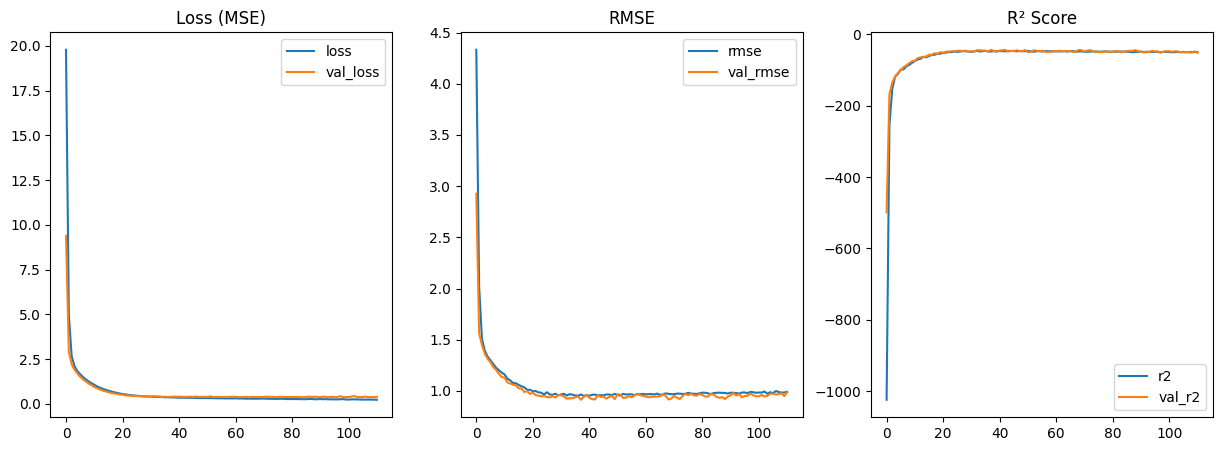

In [9]:
# Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.title("Loss (MSE)")
plt.legend()

# RMSE
plt.subplot(1, 3, 2)
plt.plot(r.history["rmse"], label="rmse")
plt.plot(r.history["val_rmse"], label="val_rmse")
plt.title("RMSE")
plt.legend()

# R2
plt.subplot(1, 3, 3)
plt.plot(r.history["r2"], label="r2")
plt.plot(r.history["val_r2"], label="val_r2")
plt.title("R² Score")
plt.legend()
plt.show()


#### 7. Avaliação final

In [10]:
# Predição
y_pred = model.predict(x_test).flatten()

# Cálculo das métricas finais
mse  = mean_squared_error(y_test, y_pred)
rmse_val = sqrt(mse)
r2_val   = r2_score(y_test, y_pred)

print("\n--- RESULTADOS FINAIS ---")
print("mse     = ", mse)
print("rmse    = ", rmse_val)
print("r2      = ", r2_val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- RESULTADOS FINAIS ---
mse     =  0.3658636939885616
rmse    =  0.6048666745561054
r2      =  0.40855578642920065


####8. Análise dos Resultados

**1- Gráficos de Avaliação do Modelo (Loss):** A análise das curvas de perda (loss) durante o treino demonstra um comportamento de convergência saudável. Observa-se uma queda acentuada do erro (MSE) nas primeiras épocas, indicando que a rede neural conseguiu extrair rapidamente os padrões principais das características físico-químicas.

Ao longo do processo, as curvas de treino e validação mantiveram-se próximas e estabilizaram em paralelo, sem que a curva de validação divergisse para valores mais altos. Isto indica que não houve overfitting (sobreajuste) significativo, ou seja, o modelo manteve a capacidade de generalização para dados novos, auxiliado pela técnica de Early Stopping que interrompeu o treino no momento ideal.
<br>
<br>


**2- Métricas de Avaliação do Modelo (R², MSE e RMSE):** O modelo obteve um R² (Coeficiente de Determinação) de aproximadamente 0.41. Este valor indica que a rede neural consegue explicar cerca de 41% da variância na qualidade dos vinhos com base nas 11 variáveis químicas fornecidas. Embora pareça um valor moderado, é um resultado consistente para este conjunto de dados (Wine Quality), dado que a atribuição de notas de qualidade a vinhos possui uma componente subjetiva humana que não é totalmente captada apenas pelas medições laboratoriais.

Em termos práticos, o RMSE (Raiz do Erro Quadrático Médio) de 0.60 revela-se a métrica mais importante: significa que, em média, as previsões do modelo desviam-se da nota real por apenas 0.6 pontos (numa escala de 0 a 10). Considerando a subjetividade do problema, um erro médio inferior a 1 ponto demonstra que a arquitetura implementada é funcional e capaz de realizar estimativas úteis e próximas da realidade.

---

# Fim do código